# Fault Detection in Wastewater Treatment Plants: Application of Autoencoders with Streaming Data

### Notebook developed to implement the fault detection system described in the paper *Fault Detection in Wastewater Treatment Plants: Application of Autoencoders with Streaming Data*

### Data obtained with the BSM2 simulator.

In [ ]:
# Load libraries needed by the project
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timezone
import statsmodels.api as sm
import scipy.stats as st
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.models import load_model
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Load dataset
df1 = pd.read_csv('/content/drive/MyDrive/Autoencoder/datasets/DO_falhas2_csv.csv', sep=';')

df_normal = pd.read_csv('/content/drive/MyDrive/Autoencoder/datasets/sensor_DO_normal.csv', sep=';')

In [ ]:
df1.head()

,time,value
0,0.000000,0.244862
1,0.010417,2.766354
2,0.020833,1.801208
3,0.031250,2.127110
4,0.041667,1.963473


In [ ]:
# Create dataframe with dates and values of DO levels.
df = pd.DataFrame()
df['Date'] = df1.time
df['value'] = df1.value

In [ ]:
df_normal1 = pd.DataFrame()
df_normal1['Date'] = df_normal.time
df_normal1['value'] = df_normal.value

In [ ]:
# Adjust stuck anomaly value
# Check indices of anomalous samples
df1.loc[df1['time'] == 30]

# Adjust Drift Values

index1 = df.index[df['Date']>=40].tolist()
index2 = df.index[df['Date']<=43].tolist()
max(index2)
min(index1)
for i in range(2880,3168):
  df.loc[i,'value'] = df.loc[i,'value']+0.5

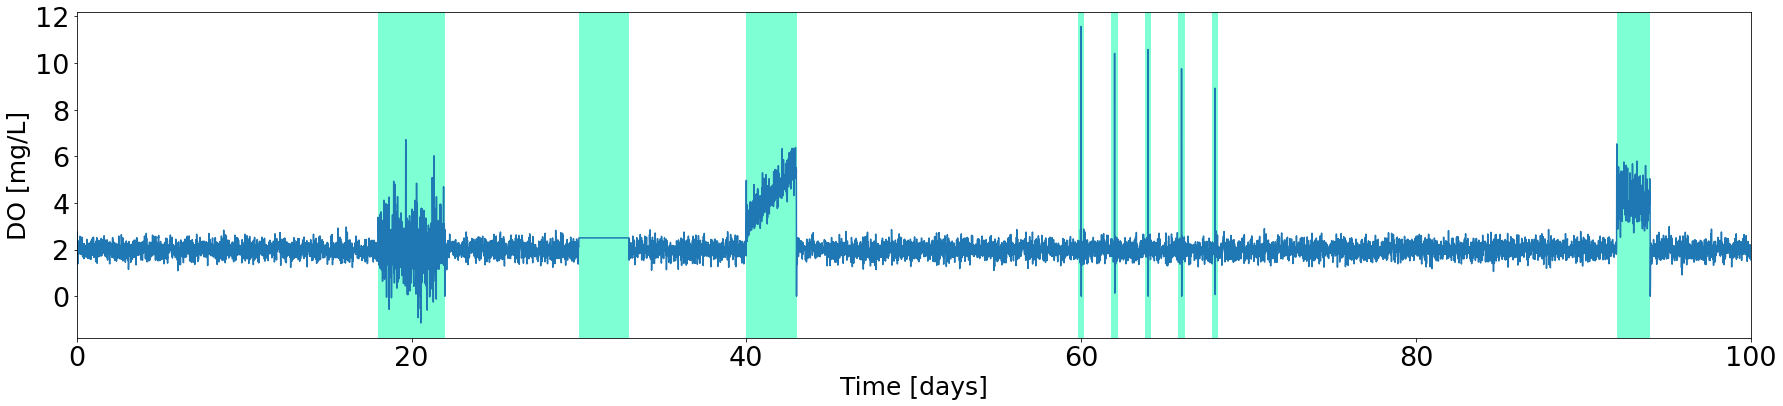

In [ ]:
# Graph of the time series and implemented failures 
plt.figure(figsize = (30, 6))
#p = sns.lineplot(x="time", y="value", data=df1[0:8640])
p = sns.lineplot(x="Date", y="value", data=df[0:10000])
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.xlim(0,100)

p.axvspan(40, 43, facecolor='aquamarine')
p.axvspan(92, 94, facecolor='aquamarine')
p.axvspan(18, 22, facecolor='aquamarine')
#p.axvspan(60, 68, facecolor='aquamarine')

p.axvspan(59.8, 60.2, facecolor='aquamarine')
p.axvspan(61.8, 62.2, facecolor='aquamarine')
p.axvspan(63.8, 64.2, facecolor='aquamarine')
p.axvspan(65.8, 66.2, facecolor='aquamarine')
p.axvspan(67.8, 68.2, facecolor='aquamarine')




p.axvspan(30, 33, facecolor='aquamarine')

#plt.savefig('/content/drive/MyDrive/Autoencoder/falhas_caso2_25_07.pdf', dpi=500, format='pdf', bbox_inches='tight')

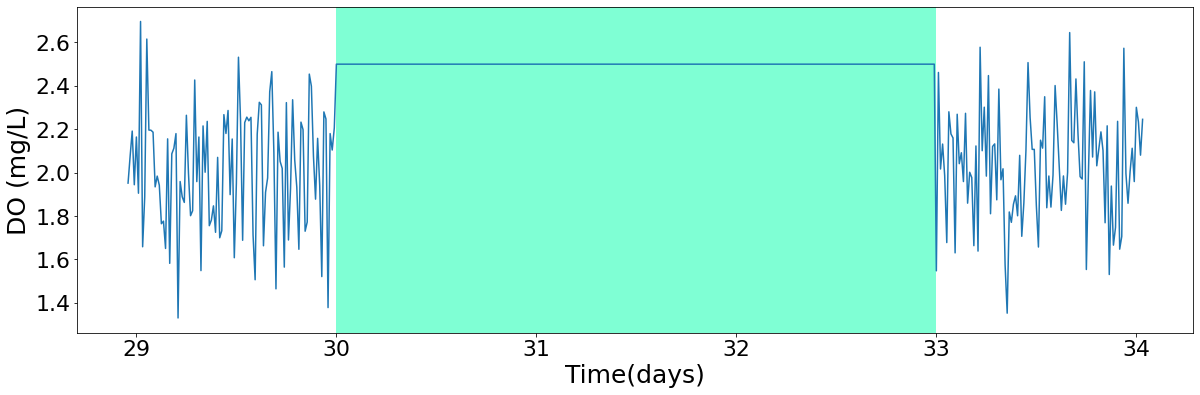

In [ ]:
# Graph of an individual failure
plt.figure(figsize = (20, 6))
#p = sns.lineplot(x="time", y="value", data=df1[0:8640])
p = sns.lineplot(x="Date", y="value", data=df[2780:3268])
plt.xlabel('Time(days)', fontsize=25)
plt.ylabel('DO (mg/L)', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

p.axvspan(30, 33, facecolor='aquamarine')



#plt.savefig('/content/drive/MyDrive/Autoencoder/fig_BSM2_caso_2/stuck_caso2.pdf', dpi=500, format='pdf', bbox_inches='tight')

## Data processing

### Split dataset into training and testing sets

In [ ]:
df1_treino = df_normal1.iloc[0:10000,:]
df1_teste = df.iloc[0:10000,:]

In [ ]:
df1_treino.to_csv('df_treino_bsm2.csv')

In [ ]:
# Using time as index
df1_treino = pd.read_csv('df_treino_bsm2.csv', parse_dates=True, index_col="Date")

In [ ]:
# Delete column created with old indexes
df1_treino = df1_treino.drop(columns=['Unnamed: 0'])

In [ ]:
df1_treino.head()

,value
Date,
0.000000,0.244862
0.010417,2.766354
0.020833,1.801208
0.031250,2.127110
0.041667,1.963473


(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5]),
 <a list of 8 Text major ticklabel objects>)

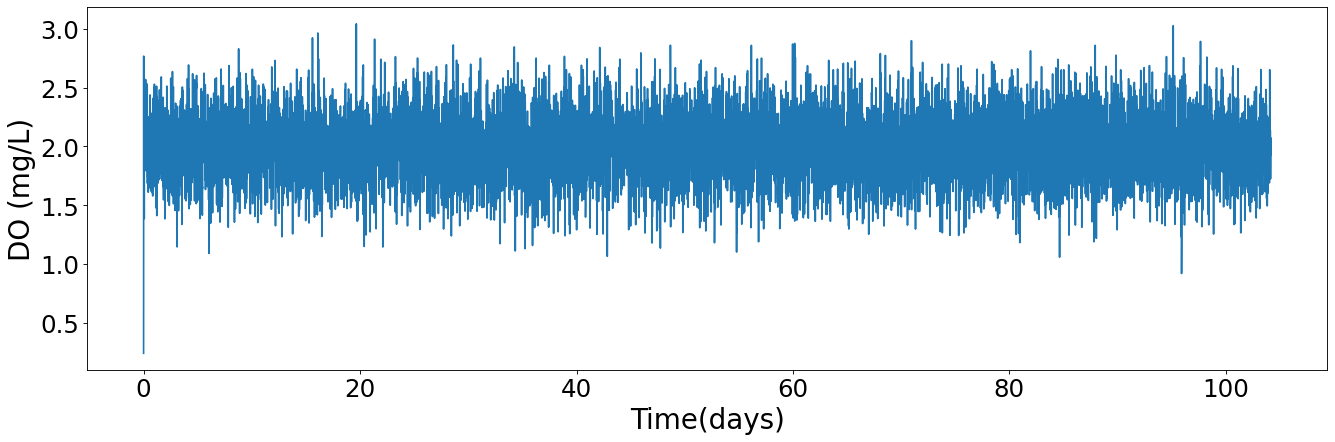

In [ ]:
# Graph
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

#plt.figure(figsize = (15, 6))
p = sns.lineplot(x="Date", y="value", data=df1_treino)

#df1_treino = df1.iloc[9500:15361,:]

# plt.scatter(df_subset.id2.iloc[0:420],df_subset.value.iloc[0:420], color="r")
# plt.plot(df1_teste.id1.iloc[800:1600], df1_teste.value.iloc[800:1600])

plt.xlabel('Time(days)', fontsize=25)
plt.ylabel('DO (mg/L)', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

#plt.savefig('/content/drive/MyDrive/Autoencoder/DO_normal_25_05.pdf', dpi=500, format='pdf', bbox_inches='tight')

## Implementing Autoencoders

In [ ]:
# Normalizing the datas
training1_mean = df1_treino.mean()
training1_std = df1_treino.std()
df1_training_value = (df1_treino - training1_mean) / training1_std
print("Number of training samples:", len(df1_training_value))  

Number of training samples: 10000


In [ ]:
# Create the window that will go through the sequence
TIME_STEPS = 96

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df1_training_value.values) 

In [ ]:
x_train.shape

(9904, 96, 1)

## Creating the model

In [ ]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 48, 32)            256       
                                                                 
 dropout (Dropout)           (None, 48, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 48, 16)           1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 48, 16)            0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 96, 32)           3616      
 ranspose)                                              

In [ ]:
# Training the model
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
70/70 [==============================] - 14s 18ms/step - loss: 0.5078 - val_loss: 0.0775
Epoch 2/50
70/70 [==============================] - 1s 10ms/step - loss: 0.1674 - val_loss: 0.0483
Epoch 3/50
70/70 [==============================] - 1s 10ms/step - loss: 0.1350 - val_loss: 0.0382
Epoch 4/50
70/70 [==============================] - 1s 10ms/step - loss: 0.1192 - val_loss: 0.0302
Epoch 5/50
70/70 [==============================] - 1s 10ms/step - loss: 0.1089 - val_loss: 0.0275
Epoch 6/50
70/70 [==============================] - 1s 10ms/step - loss: 0.1003 - val_loss: 0.0257
Epoch 7/50
70/70 [==============================] - 1s 10ms/step - loss: 0.0932 - val_loss: 0.0268
Epoch 8/50
70/70 [==============================] - 1s 10ms/step - loss: 0.0865 - val_loss: 0.0269
Epoch 9/50
70/70 [==============================] - 1s 10ms/step - loss: 0.0796 - val_loss: 0.0296
Epoch 10/50
70/70 [==============================] - 1s 10ms/step - loss: 0.0735 - val_loss: 0.0345
Epoch 11

In [ ]:
model = load_model('/content/drive/MyDrive/Autoencoder/modelos/model_autoencoder_conv1.h5')

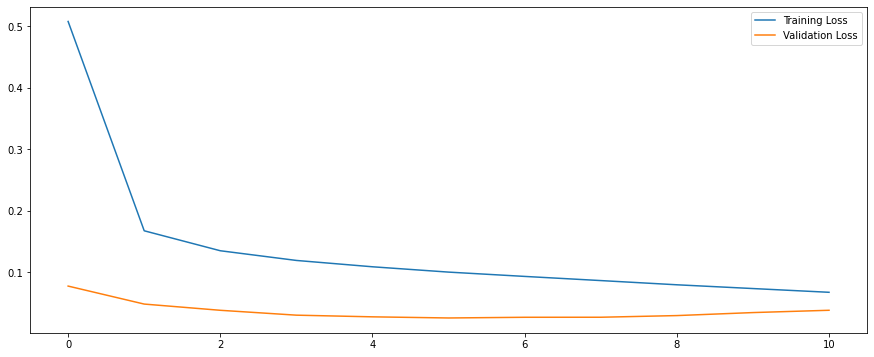

In [ ]:
# plt.figure(figsize = (15, 6))
# plt.plot(history.history["loss"], label="Training Loss")
# plt.plot(history.history["val_loss"], label="Validation Loss")
# plt.legend()
# plt.show()

Reconstruction error threshold:  0.24275672423520991


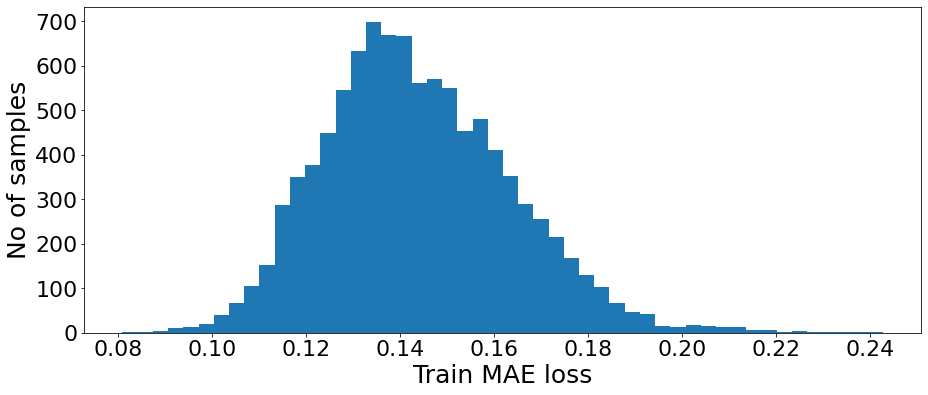

In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
plt.figure(figsize = (15, 6))
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss", fontsize=25)
plt.ylabel("No of samples", fontsize=25)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


plt.savefig('/content/drive/MyDrive/Autoencoder/fig_BSM2_caso_2/reconstucao_erro_conv2.pdf', dpi=500, format='pdf', bbox_inches='tight')
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

plt.show()

In [ ]:
threshold = 0.222306 # The thresholds must be the same as the first model (case1)

In [ ]:
df1_teste.to_csv('df_teste_bsm2.csv')
# Using time as index
df1_teste = pd.read_csv('df_teste_bsm2.csv', parse_dates=True, index_col="Date")
# Delete column created with old indexes
df1_teste = df1_teste.drop(columns=['Unnamed: 0'])

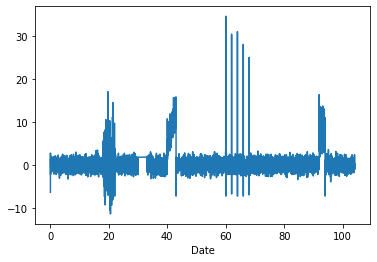

Test input shape:  (9904, 96, 1)


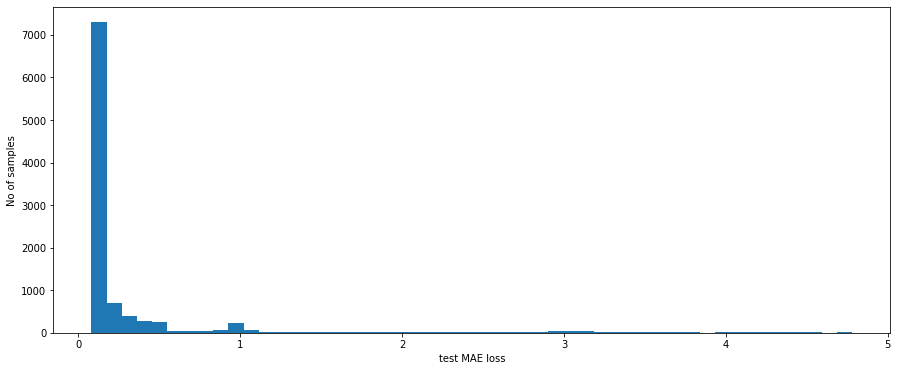

Number of anomaly samples:  1960
Indices of anomaly samples:  (array([1636, 1638, 1640, ..., 9022, 9023, 9144]),)


In [ ]:
df_test_value = (df1_teste - training1_mean) / training1_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))
plt.figure(figsize = (15, 6))
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [ ]:
# Anomalous values
df_subset = df1_teste.iloc[anomalous_data_indices] # Valores anomalos

In [ ]:
# Create column with indexes to facilitate plots
df_subset['id2'] = df_subset.index
df1_teste['id1'] = df1_teste.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Results

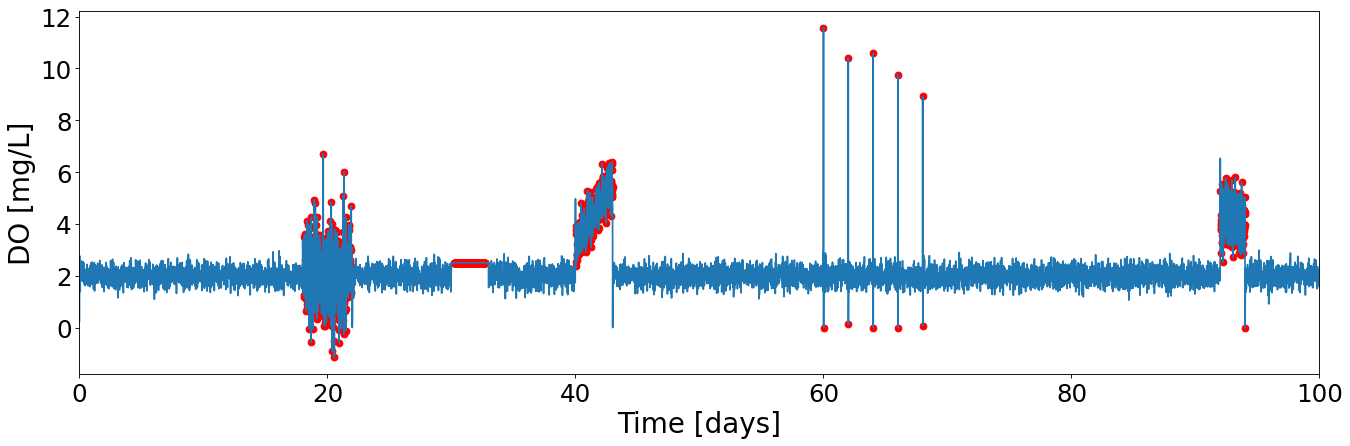

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(0,100)

plt.scatter(df_subset.id2,df_subset.value, color="r")
plt.plot(df1_teste.id1, df1_teste.value)

plt.savefig('/content/drive/MyDrive/Autoencoder/resultado_total_conv2.pdf', dpi=500, format='pdf', bbox_inches='tight')

## Graph with individual results

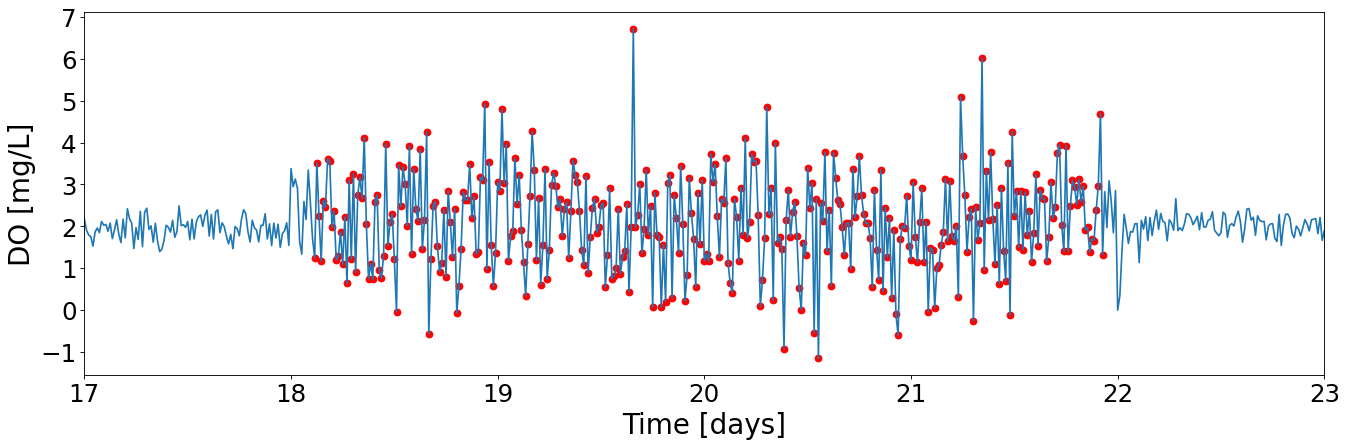

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[0:367],df_subset.value.iloc[0:367], color="r")
plt.plot(df1_teste.id1.iloc[1628:2212], df1_teste.value.iloc[1628:2212])
plt.xlim(17,23)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('/content/drive/MyDrive/Autoencoder/figura_conv_2/resultado_PD2_conv.pdf', dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# Calculation of delay in detection of failures

# Identify the first failure detection time
#df_subset.loc[df_subset['id2'] >= 18].head(1) # 18.114583

# Identify the time of the first failure sample
df1_teste.loc[df1_teste['id1'] >= 18].head(1) #18.0

# Do the math for the fraction that equals 15 min.
#((18.114583 - 18.0)*15)/0.010416666666666666 # 164.9995199999995

,value,id1
Date,,
18.0,3.379894,18.0


In [ ]:
# Count number of anomalies: DEGRADATION
cont = 0
for i in df_subset['id2']:
  if i >= 18 and i <= 22:
    cont = cont + 1
print('Nº de anomalias para a falha Degradation: ',cont)



cont2 = 0
for i in df1_teste['id1']:
  if i >= 18 and i <= 22:
    cont2 = cont2 + 1
print('Nº de amostras totais para a falha Degradation: ',cont2)

Nº de anomalias para a falha Degradation:  367
Nº de amostras totais para a falha Degradation:  385


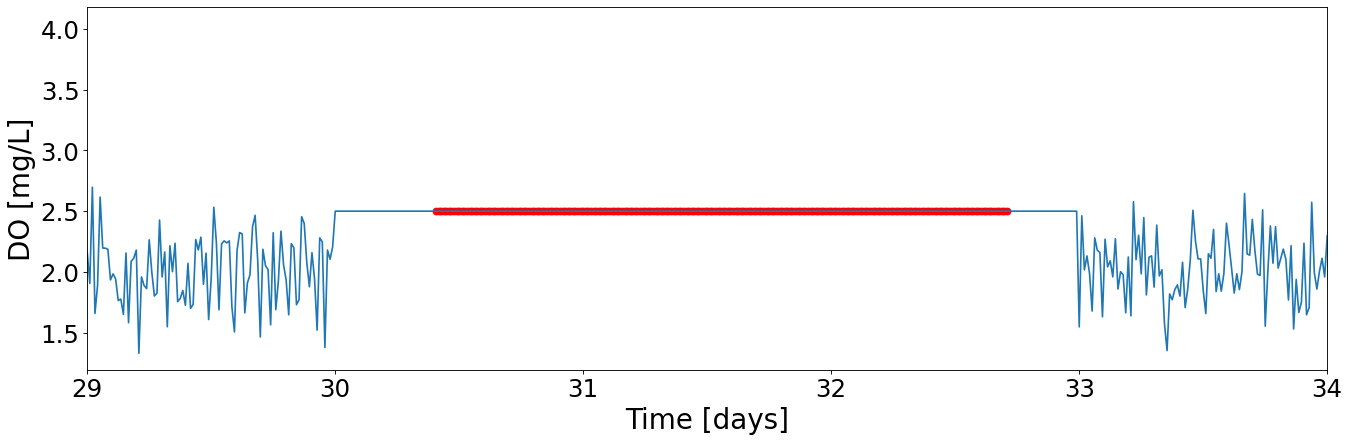

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[367:610],df_subset.value.iloc[367:610], color="r")
plt.plot(df1_teste.id1.iloc[2780:3268], df1_teste.value.iloc[2780:3268])
plt.xlim(29,34)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('/content/drive/MyDrive/Autoencoder/figura_conv_2/resultado_stuck2_conv.pdf', dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# Calculation of delay in detection of failures 

# Identify the first failure detection time
#df_subset.loc[df_subset['id2'] >= 30].head(3) # 30.218750	

# Identify the time of the first failure sample
#df1_teste.loc[df1_teste['id1'] >= 30].head(1) #30.0

# Do the math for the fraction that equals 15 min.
((30.218750 - 30.0)*15)/0.010416666666666666 # 315.0

In [ ]:
# Count number of anomalies
cont = 0
for i in df_subset['id2']:
  if i >= 30 and i <= 33:
    cont = cont+1
print('Nº de anomalias para a falha Stuck: ',cont)



cont2 = 0
for i in df1_teste['id1']:
  if i >= 30 and i <= 33:
    cont2 = cont2 + 1
print('Nº de amostras totais para a falha Stuck: ',cont2)

Nº de anomalias para a falha Stuck:  243
Nº de amostras totais para a falha Stuck:  289


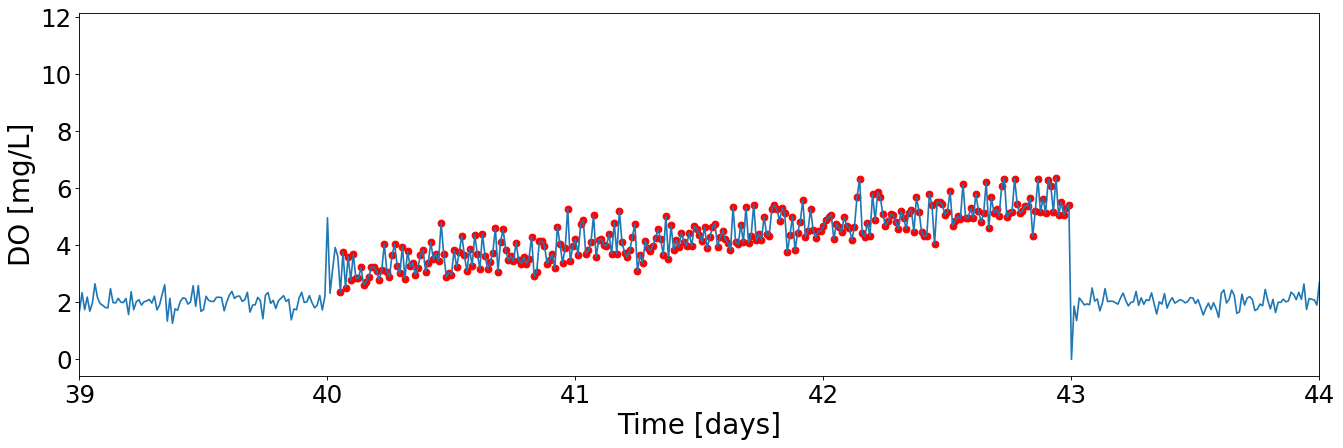

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[500:899],df_subset.value.iloc[500:899], color="r")
plt.plot(df1_teste.id1.iloc[3740:4228], df1_teste.value.iloc[3740:4228])
plt.xlim(39,44)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('/content/drive/MyDrive/Autoencoder/figura_conv_2/resultado_drift2_conv.pdf', dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# Calculation of delay in detection of failures

# Identify the first failure detection time
#df_subset.loc[df_subset['id2'] >= 40].head(3) # 40.031250	

# Identify the time of the first failure sample
#df1_teste.loc[df1_teste['id1'] >= 40].head(1) #40.0

# Do the math for the fraction that equals 15 min.
((40.031250 - 40.0)*15)/0.010416666666666666 # 45.0

45.0

In [ ]:
# Count number of anomalies: drift
cont = 0
for i in df_subset['id2']:
  if i >= 40 and i <= 43:
    cont = cont+1
print('Nº de anomalias para a falha Stuck: ',cont)



cont2 = 0
for i in df1_teste['id1']:
  if i >= 40 and i <= 43:
    cont2 = cont2 + 1
print('Nº de amostras totais para a falha Stuck: ',cont2)

Nº de anomalias para a falha Stuck:  285
Nº de amostras totais para a falha Stuck:  289


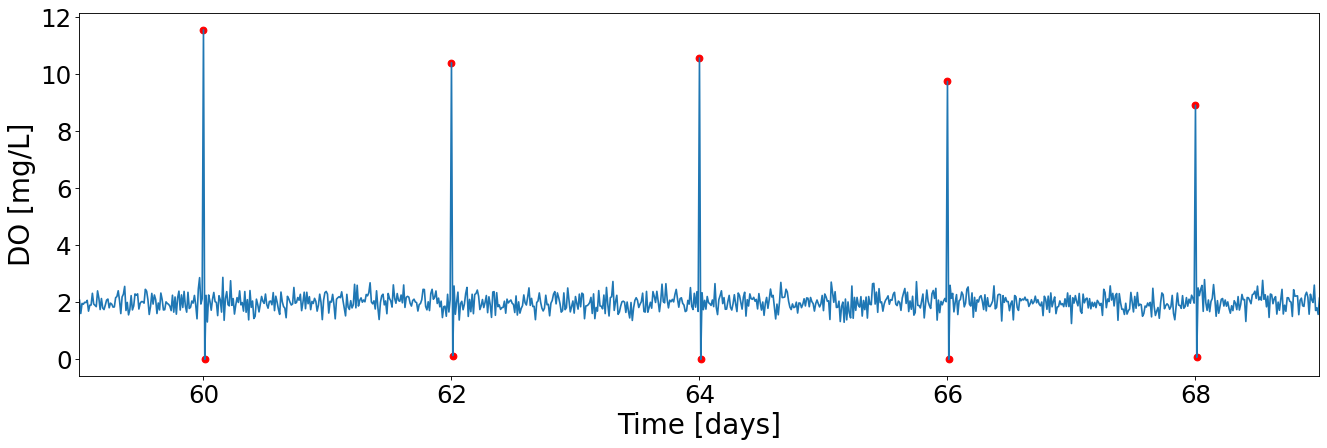

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[800:950],df_subset.value.iloc[800:950], color="r")
plt.plot(df1_teste.id1.iloc[5660:6628], df1_teste.value.iloc[5660:6628])
plt.xlim(59,69)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('/content/drive/MyDrive/Autoencoder/figura_conv_2/resultado_spike2_conv.pdf', dpi=500, format='pdf', bbox_inches='tight')

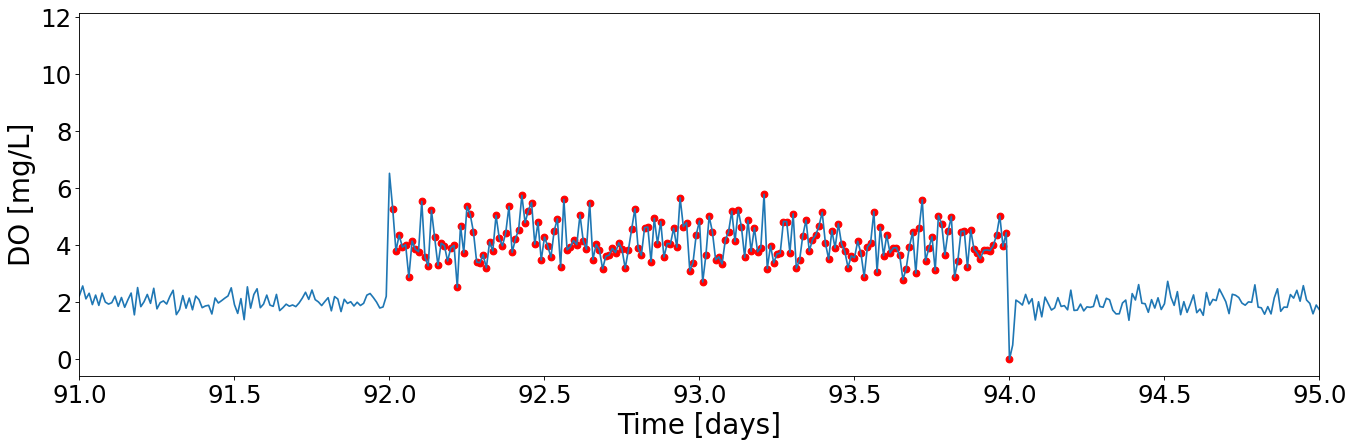

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[805:1097],df_subset.value.iloc[805:1097], color="r")
plt.plot(df1_teste.id1.iloc[8732:9124], df1_teste.value.iloc[8732:9124])
plt.xlim(91,95)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('/content/drive/MyDrive/Autoencoder/figura_conv_2/resultado_bias2_conv.pdf', dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# Calculation of delay in detection of failures

# Identify the first failure detection time
#df_subset.loc[df_subset['id2'] >= 92].head(3) # 92.010417

# Identify the time of the first failure sample
#df1_teste.loc[df1_teste['id1'] >= 92].head(1) #92.0

# Do the math for the fraction that equals 15 min.
((92.010417 - 92.0)*15)/0.010416666666666666 # 15.00048000000561

15.00048000000561

In [ ]:
# Count number of anomalies: drift
cont = 0
for i in df_subset['id2']:
  if i >= 92 and i <= 94:
    cont = cont+1
print('Nº de anomalias para a falha Stuck: ',cont)



cont2 = 0
for i in df1_teste['id1']:
  if i >= 92 and i <= 94:
    cont2 = cont2 + 1
print('Nº de amostras totais para a falha Stuck: ',cont2)

Nº de anomalias para a falha Stuck:  192
Nº de amostras totais para a falha Stuck:  193
